# Loading Packages

In [1]:
# Installing packages
!pip install transformers #nlp architecture
!pip install sentence-transformers #text embedding method

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.4 MB/s 
     |████████████████████████████████| 7.6 MB 37.9 MB/s 
     |████████████████████████████████| 182 kB 75.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.5 MB/s 
     |████████████████████████████████| 1.3 MB 30.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=d9782389b9e325ef0154efa2a47770bc58b39c1bd6b0eecdaa8b1fd65db781bd
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


# Importing Libraries

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, KLDivLoss
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from transformers import RobertaModel, BertPreTrainedModel, RobertaConfig


# Data and Evaluation

In [3]:
# Loading data
train_df = pd.read_csv('/content/train.csv', encoding='utf-8')
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# Removing data columns that are not required
train_df = train_df.drop(['id','qid1','qid2'],axis=1)
train_df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
# random sampling the data
training_df = train_df.sample(frac=1)
training_df

,question1,question2,is_duplicate
146920,What are the key differences between the HBO s...,Does Silicon Valley (HBO Show) have enough vie...,0
123569,How much money has the James Bond film franchi...,What is your favorite James Bond movie and why?,0
373181,How do I gain confidence in life?,How can I gain confidence in my writing?,0
266344,Ow can the drive from Edmonton to Auckland be ...,How can the drive from Edmonton to Auckland be...,1
216594,Why and how was Quora started?,When was Quora established?,1
...,...,...,...
32961,What is it like to attend Cardiff University?,Is there any scholarship for an MBA at Cardiff...,0
391287,What is the best decision you made in your life?,What has been the best decision you've made in...,1
197907,What are the reasons behind depreciation of IN...,Why does the Indian Rupee (or any other curren...,0
370017,What is the best Binary Options Directory?,Which are the best binary options sites?,0


In [6]:
# Test Train data split with 70% train and 30% test data
ratio = 0.70
  
total_rows = train_df.shape[0]
train_size = int(total_rows*ratio)

training_df = train_df[0:train_size]
test_df = train_df[train_size:]

# Models and Evaluation

## 1. RoBerta Model

In [8]:
# Instatiating the roberta Model 
model = SentenceTransformer('stsb-roberta-large')

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [49]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/stsb-roberta-large")

tokenizer

PreTrainedTokenizerFast(name_or_path='sentence-transformers/stsb-roberta-large', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

In [50]:
# tokens1 = tokenizer.batch_encode_plus(training_df['question1'])
# tokens2 = tokenizer.batch_encode_plus(training_df['question2'])

TypeError: ignored

In [51]:
#tokens1['input_ids']

NameError: ignored

In [ ]:
# def tokenize_function(sampleData):
#     return tokenizer(training_df, padding=512, truncation=True)


# tokenized_datasets = training_df.map(tokenize_function, batched=True)

In [ ]:
# input1 = tokens1['input_ids']
# attention1 = tokens1['attention_mask']
# input2 = tokens2['input_ids']
# attention2 = tokens2['attention_mask']

In [ ]:
# data = TensorDataset(input1, attention1, input2, attention2, labels)

In [ ]:
# classifier = Sequential([
#     model,
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# classifier.fit(data, epochs=5)

In [11]:
# Preview of the questions
training_df['question1'].head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
Name: question1, dtype: object

In [12]:
training_df['question2'].head()

0    What is the step by step guide to invest in sh...
1    What would happen if the Indian government sto...
2    How can Internet speed be increased by hacking...
3    Find the remainder when [math]23^{24}[/math] i...
4              Which fish would survive in salt water?
Name: question2, dtype: object

In [13]:
# Since the data is large sampling will be necessary
training_df = training_df.sample(1000,random_state=2)
training_df=training_df.reset_index(drop=True)
training_df.head()

,question1,question2,is_duplicate
0,League of Legends: What makes for a well execu...,Who makes the music for League of Legends?,0
1,How many enlightened persons exists in the 21s...,How many enlightened human beings are there in...,0
2,How stay focused and motivated for IIT JEE?,How do I stay highly motivated for JEE prepara...,1
3,What's your opinion on GMO products? Do you fe...,What is your opinion on GMO products? Do you s...,1
4,What universities does Ring Energy recruit new...,What universities does PDC Energy recruit new ...,0


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


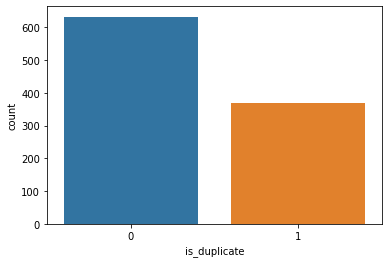

In [14]:
# Visualizing the unique and dulpicate question distribution
sns.countplot(training_df['is_duplicate'])

In [15]:
training_df = training_df.dropna()

In [16]:
# Changing the questions to list
q1 = training_df['question1'].to_list()
q2 = training_df['question2'].to_list()

In [17]:
ques1Emb = model.encode(q1, convert_to_tensor=True)
ques2Emb = model.encode(q2, convert_to_tensor=True)

In [18]:
# Cosine similarity
cosineSimilarity = []

for i in range(len(ques1Emb)):
    similarityScore=util.cos_sim(ques1Emb[i],ques2Emb[i])
    cosineSimilarity.append(similarityScore[0].item())
    
training_df['CS'] = cosineSimilarity 

In [19]:
def setThreshold(cs, threshold):
    if(cs<threshold):
        label=0
    else:
        label=1
        
    return label 

In [20]:
training_df['prediction']=training_df['CS'].apply(lambda x: setThreshold(x, 0.6))  

In [21]:
# Since the data is large sampling will be necessary
test_df = test_df.sample(400,random_state=2)
test_df=test_df.reset_index(drop=True)
test_df.head()

,question1,question2,is_duplicate
0,How could I apply for private medical colleges...,How do I apply for gujarat private medical col...,0
1,Is there a great Android app that let's you wr...,Is there an Android app that finds a font base...,0
2,How do I survive in a long distance relationship?,What does it take for a successful long distan...,1
3,What are some good ways to reduce arm fat?,How do I burn the fat around my waist?,0
4,What is the newest business model in America now?,What is the newest business model in 2014?,0


In [22]:
# Coverting the test data to a list
testQ1 = test_df['question1'].to_list()
testQ2 = test_df['question2'].to_list()

In [23]:
testEmb1 = model.encode(testQ1, convert_to_tensor=True)
testEmb2 = model.encode(testQ2, convert_to_tensor=True)

In [24]:
# Cosine similarity
cosineSimilarity = []

for i in range(len(testEmb1)):
    similarityScore=util.cos_sim(testEmb1[i],testEmb2[i])
    cosineSimilarity.append(similarityScore[0].item())
    
test_df['CS'] = cosineSimilarity 

In [25]:
# Applying the function for prediction
test_df['prediction']=test_df['CS'].apply(lambda x: setThreshold(x, 0.6))
test_df.head()

,question1,question2,is_duplicate,CS,prediction
0,How could I apply for private medical colleges...,How do I apply for gujarat private medical col...,0,0.733656,1
1,Is there a great Android app that let's you wr...,Is there an Android app that finds a font base...,0,0.520875,0
2,How do I survive in a long distance relationship?,What does it take for a successful long distan...,1,0.807846,1
3,What are some good ways to reduce arm fat?,How do I burn the fat around my waist?,0,0.442484,0
4,What is the newest business model in America now?,What is the newest business model in 2014?,0,0.593756,0


In [26]:
training_df.head()

,question1,question2,is_duplicate,CS,prediction
0,League of Legends: What makes for a well execu...,Who makes the music for League of Legends?,0,0.428140,0
1,How many enlightened persons exists in the 21s...,How many enlightened human beings are there in...,0,0.604745,1
2,How stay focused and motivated for IIT JEE?,How do I stay highly motivated for JEE prepara...,1,0.884885,1
3,What's your opinion on GMO products? Do you fe...,What is your opinion on GMO products? Do you s...,1,0.764358,1
4,What universities does Ring Energy recruit new...,What universities does PDC Energy recruit new ...,0,0.792331,1


In [27]:
rbf1_score = f1_score(test_df['is_duplicate'],test_df['prediction'])
rbf1_score

0.6728971962616823

## 2. Bert Model

In [28]:
# Instantiate the Bert model
model1 = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [31]:
# Parameters
params = list(model1.named_parameters())

In [33]:
# Embedding
testEmb_b1 = model1.encode(testQ1, convert_to_tensor=True)
testEmb_b2 = model1.encode(testQ2, convert_to_tensor=True)

In [34]:
# Cosine similarity
cosineSimilarity = []

for i in range(len(testEmb_b1)):
    similarityScore=util.cos_sim(testEmb_b1[i],testEmb_b2[i])
    cosineSimilarity.append(similarityScore[0].item())
test_df['CS'] = cosineSimilarity 

In [35]:
# Applying the function for prediction
test_df['prediction']=test_df['CS'].apply(lambda x: setThreshold(x, 0.6))
test_df.head()

,question1,question2,is_duplicate,CS,prediction
0,How could I apply for private medical colleges...,How do I apply for gujarat private medical col...,0,0.910859,1
1,Is there a great Android app that let's you wr...,Is there an Android app that finds a font base...,0,0.646312,1
2,How do I survive in a long distance relationship?,What does it take for a successful long distan...,1,0.830420,1
3,What are some good ways to reduce arm fat?,How do I burn the fat around my waist?,0,0.549708,0
4,What is the newest business model in America now?,What is the newest business model in 2014?,0,0.740962,1


In [36]:
bertf1_score = f1_score(test_df['is_duplicate'],test_df['prediction'])
bertf1_score

0.6182572614107883

## 3. Distilbert Model

In [37]:
# Instantiate the model
distilModel = SentenceTransformer('sentence-transformers/msmarco-distilbert-cos-v5')
# Fine tuning
optimizer = torch.optim.Adam(distilModel.parameters(), lr=0.01)


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/319 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [38]:
# Encoding query and documents
testEmb_dis1 = distilModel.encode(testQ1, convert_to_tensor=True)
testEmb_dis2 = distilModel.encode(testQ2, convert_to_tensor=True)

In [39]:
# Cosine similarity
cosineSimilarity = []

for i in range(len(testEmb_dis1)):
    similarityScore=util.cos_sim(testEmb_dis1[i], testEmb_dis2[i])
    cosineSimilarity.append(similarityScore[0].item())
test_df['CS'] = cosineSimilarity 


In [40]:
# Applying the function for prediction
test_df['prediction']=test_df['CS'].apply(lambda x: setThreshold(x, 0.6))
test_df.head()

,question1,question2,is_duplicate,CS,prediction
0,How could I apply for private medical colleges...,How do I apply for gujarat private medical col...,0,0.685307,1
1,Is there a great Android app that let's you wr...,Is there an Android app that finds a font base...,0,0.437584,0
2,How do I survive in a long distance relationship?,What does it take for a successful long distan...,1,0.726312,1
3,What are some good ways to reduce arm fat?,How do I burn the fat around my waist?,0,0.502106,0
4,What is the newest business model in America now?,What is the newest business model in 2014?,0,0.748542,1


In [41]:
df1_score = f1_score(test_df['is_duplicate'],test_df['prediction'])
df1_score

0.6683804627249358

# Conclusion

Three different pre-trained models have been used.

The metrics used for evaluation of  best model is f1 score

Therefore, in text similarity the Roberta model is the best to use.